# Imports

In [2]:
from diffusion_imaging.handlers import HCPLocalHandler
from diffusion_imaging.models import FreeWaterTensorModel
from diffusion_imaging.preprocessing import PreprocessContainer
from dipy.reconst.shm import CsaOdfModel
from dipy.direction import peaks_from_model
from dipy.data import default_sphere
import dipy.reconst.dti as dti
import matplotlib.pyplot as plt
import numpy as np
import sys

# Load files

In [3]:
dwi_file = "D:\\Users\\boywi\\Downloads\\Diffusion"

config = {
    'patient_directory': dwi_file
}
h = HCPLocalHandler(config=config)
patients = h.load()

C:\Users\boywi\Miniconda3\envs\dmipy\lib\site-packages\dmipy-0.1.dev0-py3.7.egg\dmipy\core\acquisition_scheme.py:871: UserWarning: pulse_separation (big_delta) or pulse_duration (small_delta) are not defined in the Dipy gtab. This means the resulting DmipyAcquisitionScheme cannot be used with CompartmentModels that need these.


# Preprocess

In [4]:
masker = PreprocessContainer.mask()

for patient in patients:
    patient.mri.mask_data, patient.mri.mask = masker.process(patient.mri.data)

# Sticks and Ball Model

In [5]:
csamodel = CsaOdfModel(patients[0].mri.gradient_table, 4)

In [6]:
csapeaks = peaks_from_model(model=csamodel,
                            data=patients[0].mri.mask_data,
                            sphere=default_sphere,
                            relative_peak_threshold=.5,
                            min_separation_angle=25,
                            mask=patients[0].mri.mask,
                            return_odf=False,
                            normalize_peaks=True)

GFA = csapeaks.gfa

print('GFA.shape (%d, %d, %d)' % GFA.shape)

GFA.shape (145, 174, 145)


In [28]:
dir(patients[0].mri)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_result',
 'data',
 'gradient_table',
 'mask',
 'mask_data',
 'nifti_image',
 'result',
 'scheme']

In [30]:
data = patients[0].mri.data
print(data[13:43, 44:74, 28:29].shape)

(30, 30, 1, 288)


In [62]:
i_start = 13
j_start = 44
k_start = 90
data_small = patients[0].mri.mask_data[i_start:i_start+30, j_start:j_start+30, k_start:k_start+1]

from dipy.viz import window, actor

# Enables/disables interactive visualization
interactive = False

ren = window.Renderer()

csaodfs = csamodel.fit(data_small).odf(default_sphere)

In [63]:
csaodfs = np.clip(csaodfs, 0, np.max(csaodfs, -1)[..., None])
csa_odfs_actor = actor.odf_slicer(csaodfs, sphere=default_sphere,
                                  colormap='plasma', scale=0.4)
csa_odfs_actor.display(z=0)

ren.add(csa_odfs_actor)
print('Saving illustration as csa_odfs.png')
window.record(ren, n_frames=1, out_path='csa_odfs.png', size=(600, 600))
window.show(ren)

Saving illustration as csa_odfs.png


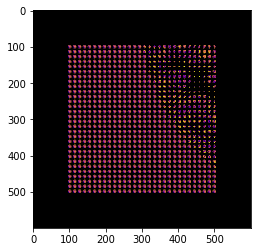

In [67]:
im = np.array(Image.open('csa_odfs.png'))
plt.imshow(im, interpolation='nearest')
plt.show()

In [12]:
from dipy.sims.voxel import sticks_and_ball
from dipy.reconst.dsi import DiffusionSpectrumModel

ds = DiffusionSpectrumModel(patients[0].mri.gradient_table)
ds_fitted = ds.fit(patients[0].mri.data)

In [14]:
from dipy.core.subdivide_octahedron import create_unit_sphere
from dipy.direction.peaks import peak_directions

sphere = create_unit_sphere(5)
odf2 = ds_fitted.odf(sphere)
directions, _, _ = peak_directions(odf2, sphere)

C:\Users\boywi\Miniconda3\envs\dmipy\lib\site-packages\dipy-1.0.0-py3.7-win-amd64.egg\dipy\reconst\dsi.py:173: RuntimeWarning: invalid value encountered in true_divide
  Pr /= Pr.sum()


KeyboardInterrupt: 

In [ ]:
directions

# Fit model for each mri

In [4]:
for patient in patients:
    for i, mri in enumerate(patient.mri_list):
        fwdtimodel = FreeWaterTensorModel(mri.gradient_table)
        fwdtifit = fwdtimodel.fit(mri.data, mri.mask)
        patient.mri_list[i].fitted_model = fwdtifit

In [5]:
gtab = patients[0].mri_list[0].gradient_table
data = patients[0].mri_list[0].data
mask = patients[0].mri_list[0].mask

In [6]:
fwdtifit = patients[0].mri_list[0].fitted_model

In [10]:
dtimodel = dti.TensorModel(gtab)

dtifit = dtimodel.fit(data, mask=mask)

dti_FA = dtifit.fa
dti_MD = dtifit.md


In [15]:
FA = fwdtifit.FA
MD = fwdtifit.MD
axial_slice = 40

In [18]:
fwdtifit.f.f

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

# Show stuff

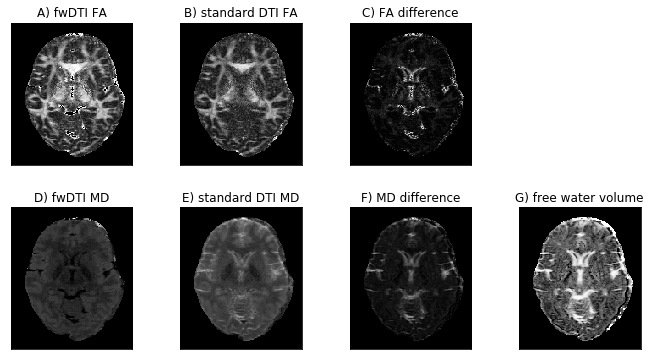

In [19]:
fig1, ax = plt.subplots(2, 4, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)
ax.flat[0].imshow(FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[0].set_title('A) fwDTI FA')

ax.flat[1].imshow(dti_FA[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[1].set_title('B) standard DTI FA')

FAdiff = abs(FA[:, :, axial_slice] - dti_FA[:, :, axial_slice])
ax.flat[2].imshow(FAdiff.T, cmap='gray', origin='lower', vmin=0, vmax=1)
ax.flat[2].set_title('C) FA difference')

ax.flat[3].axis('off')

ax.flat[4].imshow(MD[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=2.5e-3)
ax.flat[4].set_title('D) fwDTI MD')

ax.flat[5].imshow(dti_MD[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=2.5e-3)
ax.flat[5].set_title('E) standard DTI MD')


MDdiff = abs(MD[:, :, axial_slice] - dti_MD[:, :, axial_slice])
ax.flat[6].imshow(MDdiff.T, origin='lower', cmap='gray', vmin=0, vmax=2.5e-3)
ax.flat[6].set_title('F) MD difference')

F = fwdtifit.f.f

ax.flat[7].imshow(F[:, :, axial_slice].T, origin='lower',
                  cmap='gray', vmin=0, vmax=1)
ax.flat[7].set_title('G) free water volume')

plt.show()